# RAG on Neo4j database

In [59]:
import json
from neo4j import GraphDatabase
from mistralai import Mistral
from getpass import getpass

In [60]:
api_key= getpass("Type your API Key")
neo4j_password =  getpass("Type your neo4j password")
client = Mistral(api_key=api_key)

Type your API Key ········
Type your neo4j password ········


## Step 1 : Download Neo4j Desktop and check python client access 

- Install [neo4j desktop](https://neo4j.com/download/?utm_source=GSearch&utm_medium=PaidSearch&utm_campaign=Evergreen&utm_content=EMEA-Search-SEMBrand-Evergreen-None-SEM-SEM-NonABM&utm_term=download%20neo4j&utm_adgroup=download&gad_source=1&gclid=CjwKCAiArva5BhBiEiwA-oTnXcSKI5nRGi8ScnPkf68lkxJzefqgBd046ypdgCxNGptmZEa9sUKK2hoC1AYQAvD_BwE)

- Open the default project `Example Project` containing the `Movie DBMD database`

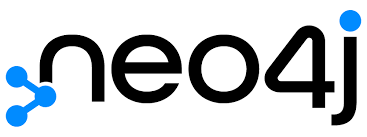

In [61]:
URI = "bolt://localhost:7687"
AUTH = ("neo4j", neo4j_password)

def run_cypher_query(cypher_query):
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        records, _, _ = driver.execute_query(cypher_query,database_="neo4j")
    return records

## Step 2 : Create a text-2-cypher agent for the Movie DBMD database
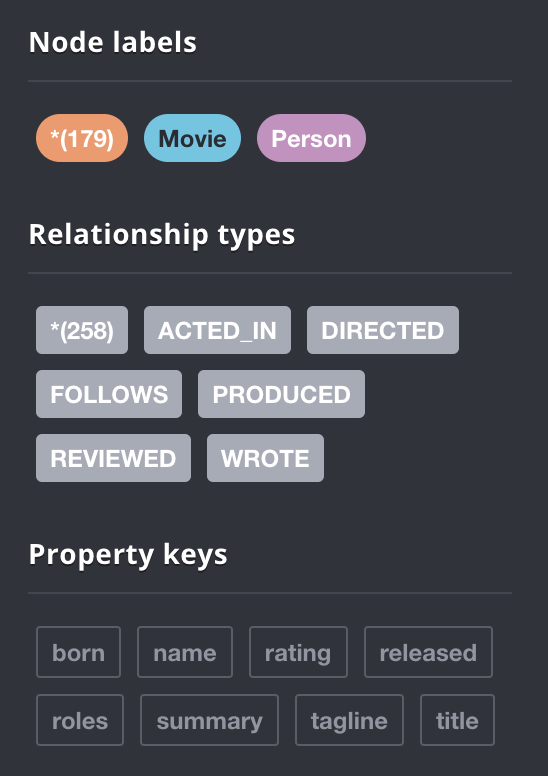


In [30]:
def generate_cypher_query(question):
    prompt = f"""You are a coding agent interacting with a Neo4j database with the following schema : 

    - Labels : "Movie", "Person"
    - Relationships : "ACTED_IN", "DIRECTED", "FOLLOWS", "PRODUCED", "REVIEWED", "WROTE"

    "Person" label has the following properties : 
    - born
    - name 

    "Movie" label has the following properties :
    - title
    - released

    Your will be given as input a query in natural language and your role is to output a cypher query whose output will contain the answer.
    Your output with be in a json format. 

    Examples : 

    input : When was the movie "The Matrix" released ?
    output : {{"result": "MATCH (n:Movie) WHERE n.title='The Matrix' RETURN n.released"}}

    input : In which movied Tom Hanks played ?
    output : {{"result": "MATCH (p:Person {{name: 'Tom Hanks'}})-[:ACTED_IN]->(m:Movie) RETURN m.title AS movieTitle"}}

    input : What movie Steven Spielber produced ?
    output : {{"result": "MATCH (p:Person {{name: 'Steven Spielberg'}})-[:PRODUCED]->(m:Movie) RETURN m.title AS movieTitle"}}

    Here is the user question :
    {question}
    """

    chat_response = client.chat.complete(
    model= model,
    response_format = {"type": "json_object"},
    messages = [
        {
            "role": "user",
            "content": prompt,
        },
    ]
    )
    return chat_response.choices[0].message.content

# Step 3 : Create a response agent 

In [53]:
def respond_to_query(question, cypher_code, query_output):
    prompt = f"""You are a coding agent interacting with a Neo4j database with the following schema : 

    - Labels : "Movie", "Person"
    - Relationships : "ACTED_IN", "DIRECTED", "FOLLOWS", "PRODUCED", "REVIEWED", "WROTE"

    "Person" label has the following properties : 
    - born
    - name 

    "Movie" label has the following properties :
    - title
    - released

    The user asked the following question :
    {question}

    To answee the question the following cypher query was run on Neo4j : 
    {cypher_code}

    The following output was obtained :
    {query_output}

    Based on all these elements answer the initial user question. 
    Be straight to the point and concise in your answers.

    Your answer:
    """

    chat_response = client.chat.complete(
    model= model,
    messages = [
        {
            "role": "user",
            "content": prompt,
        },
    ]
    )
    return chat_response.choices[0].message.content

# Step 4 : Test the end to end workflow 

In [44]:
def neo4j_agent(question):
    cypher_code = json.loads(generate_cypher_query(question))['result']
    query_result = run_cypher_query(cypher_code)
    response = respond_to_query(question, cypher_code, query_result)

    print(f'Question : \n {question} \n')
    print(f'Query : \n {cypher_code} \n')
    print(f'Response : \n {response} \n')
 

In [45]:
neo4j_agent("When was Keanue Reeves born ?")

Question : 
 When was Keanue Reeves born ? 

Query : 
 MATCH (n:Person) WHERE n.name='Keanu Reeves' RETURN n.born 

Response : 
 Keanu Reeves was born in 1964. 



In [47]:
neo4j_agent("What actors played in the movie The Matrix ?")

Question : 
 What actors played in the movie The Matrix ? 

Query : 
 MATCH (m:Movie {title: 'The Matrix'})<-[:ACTED_IN]-(p:Person) RETURN p.name AS actorName 

Response : 
 Sure, based on the executed Cypher query and the output, the actors who played in the movie "The Matrix" are Keanu Reeves, Carrie-Anne Moss, Laurence Fishburne, Hugo Weaving, and Emil Eifrem. 



In [55]:
neo4j_agent("Tell me the name of a person that is both an actor and a producer on another movie")

Question : 
 Tell me the name of a person that is both an actor and a producer on another movie 

Query : 
 MATCH (p:Person)-[:ACTED_IN]->(m:Movie)<-[:PRODUCED]-(p) WHERE p.name <> m.title RETURN DISTINCT p.name 

Response : 
 There are no people in the database that are both an actor and a producer on another movie. 



In [56]:
neo4j_agent("List Tom Hanks movies and sort them by release date")

Question : 
 List Tom Hanks movies and sort them by release date 

Query : 
 MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN m.title AS movieTitle, m.released AS releaseDate ORDER BY m.released ASC 

Response : 
 Tom Hanks has acted in several movies over the years. Here are Tom Hanks' movies sorted by their release date:

1. "Joe Versus the Volcano" (1990)
2. "A League of Their Own" (1992)
3. "Sleepless in Seattle" (1993)
4. "Apollo 13" (1995)
5. "That Thing You Do" (1996)
6. "You've Got Mail" (1998)
7. "The Green Mile" (1999)
8. "Cast Away" (2000)
9. "The Polar Express" (2004)
10. "The Da Vinci Code" (2006)
11. "Charlie Wilson's War" (2007)
12. "Cloud Atlas" (2012) 



In [58]:
neo4j_agent("We are in 2024, how old is Tom Hanks ?")

Question : 
 We are in 2024, how old is Tom Hanks ? 

Query : 
 MATCH (p:Person {name: 'Tom Hanks'}) RETURN 2024 - p.born AS age 

Response : 
 According to the provided information, Tom Hanks is 68 years old in 2024. 



In [49]:
neo4j_agent("Give me names of two actors that played together in two differnet films. Give me the names of the associated movies")

Question : 
 Give me names of two actors that played together in two differnet films. Give me the names of the associated movies 

Query : 
 MATCH (p1:Person)-[:ACTED_IN]->(m1:Movie)<-[:ACTED_IN]-(p2:Person)-[:ACTED_IN]->(m2:Movie) WHERE m1 <> m2 RETURN p1.name AS actor1, p2.name AS actor2, collect(DISTINCT m1.title) AS movies1, collect(DISTINCT m2.title) AS movies2 LIMIT 2 

Response : 
 Sure, based on the output of the Cypher query, we can see that both 'Carrie-Anne Moss' and 'Laurence Fishburne' have acted together with 'Keanu Reeves' in multiple movies, specifically 'The Matrix Reloaded' and 'The Matrix Revolutions'. However, they have also acted together in 'The Matrix' which is also included in the list of movies for 'Keanu Reeves'.

To answer the user's question, we should focus on the unique pairs of actors who have acted together in two different films. In this case, 'Carrie-Anne Moss' and 'Keanu Reeves' are the only pair that meets this criteria, with 'The Matrix Reloaded' an